Team Members

*   Roshan Rayala Bhaskar
*   Shashankh Mysore Girish







**Importing the Functions and dataset**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

[6]


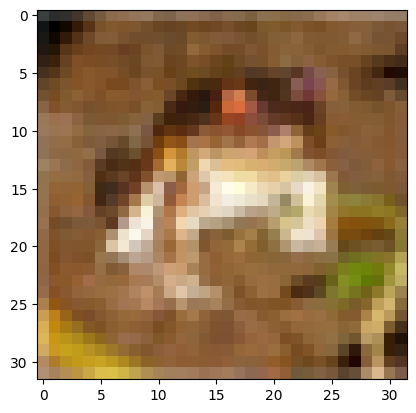

In [ ]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()

print(train_labels[0])
plt.imshow(train_images[0], cmap="Greys_r")

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


**Converting the Train and test into batches of tensor**

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.astype(np.int32)))
train_data = train_data.shuffle(buffer_size=60000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(128)

**Building a Simple CNN**

In [ ]:
train_steps = 4000

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), padding = "same", activation=tf.nn.relu, name = "conv_1", input_shape = (32, 32, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), name="maxpool_1"),
    tf.keras.layers.Conv2D(filters = 64, kernel_size=(3, 3), padding = "same", activation=tf.nn.relu, name = "conv_2"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), name="maxpool_2"),
    tf.keras.layers.Conv2D(filters = 128, kernel_size=(3, 3), padding = "same", activation=tf.nn.relu, name = "conv_3"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), name="maxpool_3"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10)
])

# Adam makes things much smoother
optimizer = tf.optimizers.Adam()
# from_logits = True!! #neverforget
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 64)        18496     
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 8, 8, 64)          0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 128)         73856     
                                                                 
 maxpool_3 (MaxPooling2D)    (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0

**Training the Model**

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (image_batch, label_batch) in enumerate(train_data):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(image_batch)
        # loss format is generally: first argument targets, second argument outputs
        loss = loss_fn(label_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    train_acc_metric(label_batch, logits)

    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: 2.303197145462036 Accuracy: 0.125
Loss: 1.6323788166046143 Accuracy: 0.28664061427116394
Loss: 1.347385048866272 Accuracy: 0.4235156178474426
Loss: 1.4745752811431885 Accuracy: 0.46507811546325684
Loss: 1.2807376384735107 Accuracy: 0.5070577263832092
Loss: 1.3238630294799805 Accuracy: 0.5497656464576721
Loss: 1.2213873863220215 Accuracy: 0.5721094012260437
Loss: 1.1269700527191162 Accuracy: 0.589062511920929
Loss: 1.187410831451416 Accuracy: 0.604924738407135
Loss: 0.9145058989524841 Accuracy: 0.6371874809265137
Loss: 0.9825383424758911 Accuracy: 0.6410156488418579
Loss: 1.1575772762298584 Accuracy: 0.662890613079071
Loss: 0.89055335521698 Accuracy: 0.6696204543113708
Loss: 0.8040446043014526 Accuracy: 0.6811718940734863
Loss: 0.9487245082855225 Accuracy: 0.6932812333106995
Loss: 0.8106650114059448 Accuracy: 0.6975781321525574
Loss: 0.7513233423233032 Accuracy: 0.6953418850898743
Loss: 0.8486337661743164 Accuracy: 0.7130468487739563
Loss: 0.8447617292404175 Accuracy: 0.7194530963

**Now we try to fool the model by adding adveserial noise**

In [ ]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
def create_adversarial_pattern(index,input_image, input_label):
      with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

      # Get the gradients of the loss w.r.t to the input image.
      gradient = tape.gradient(loss, input_image)
      # Get the sign of the gradients to create the perturbation
      signed_grad = tf.sign(gradient)
      return signed_grad

Now we add adveserial noise to the desiered image

In [ ]:
def img_to_tensor(index):
  input_image = test_images[index]
  input_image_tf = tf.convert_to_tensor(input_image.reshape([-1, 32, 32, 3]).astype(np.float32)/255)
  input_label = test_labels[index]
  input_label_tf = tf.convert_to_tensor(input_label.astype(np.int32))
  return input_image, input_label, input_image_tf, input_label_tf





**Change the index of the image set accordingly**

In [ ]:
input_image, input_label, input_image_tf, input_label_tf = img_to_tensor(100)
perturbations = create_adversarial_pattern(100,input_image_tf,input_label_tf)

**Visualization of the noise**

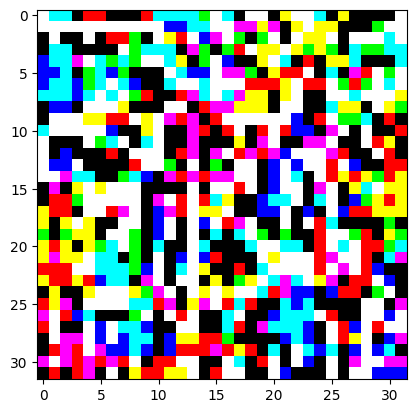

In [ ]:
plt.imshow(perturbations[0] * 0.5 + 0.5);

**Adding Petrubations to the input image**

In [ ]:
def add_petrubation(petrubation,image, eps = 0.008):
    image = image + eps * petrubation
    image = tf.clip_by_value(image, -1, 1)
    return image

In [ ]:
pertubated_image = add_petrubation(perturbations, input_image_tf)


The original Label is: [4]
1/1 [==============================] - 0s 250ms/step
The pertubated label is 7


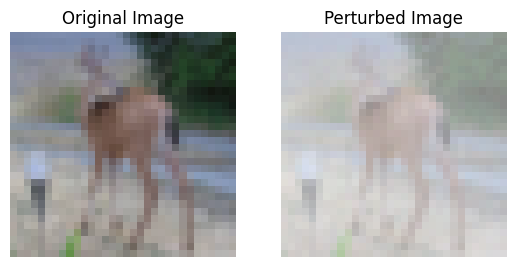

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(input_image)
print('The original Label is:', input_label)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pertubated_image[0]*0.5 + 0.5)
plt.title("Perturbed Image")
predict = model.predict(pertubated_image)
max_index = np.argmax(predict)
print('The pertubated label is', max_index)

plt.axis("off")

plt.show()



**Coverting the entire dataset into Adverseral**

In [ ]:
# Load CIFAR-10 data
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()

# Normalize the images
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Create TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=60000).batch(128).repeat()
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(128)


In [ ]:
# Function to create adversarial perturbations for the entire dataset
def create_adversarial_dataset(images, labels, model_2, loss_object, eps=0.008):
    adversarial_images = []
    print(images.shape[0])
    for i in range(0,20000):
        print('The image is', i)
        input_image = images[i]
        input_label = labels[i]

        input_image_tf = tf.convert_to_tensor(input_image.reshape([1, 32, 32, 3]))
        input_label_tf = tf.convert_to_tensor(input_label)

        with tf.GradientTape() as tape:
            tape.watch(input_image_tf)
            prediction = model_2(input_image_tf)
            loss = loss_object(input_label_tf, prediction)

        gradient = tape.gradient(loss, input_image_tf)
        signed_grad = tf.sign(gradient)

        adversarial_image = input_image + eps * signed_grad.numpy()
        adversarial_image = np.clip(adversarial_image, 0, 1)  # Clip values to the valid range

        adversarial_images.append(adversarial_image)
    print('successfully done')
    return np.array(adversarial_images)

# Generate adversarial perturbations for the entire training dataset
adversarial_train_images = create_adversarial_dataset(train_images, train_labels, model, loss_fn)



Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
The image is 15001
The image is 15002
The image is 15003
The image is 15004
The image is 15005
The image is 15006
The image is 15007
The image is 15008
The image is 15009
The image is 15010
The image is 15011
The image is 15012
The image is 15013
The image is 15014
The image is 15015
The image is 15016
The image is 15017
The image is 15018
The image is 15019
The image is 15020
The image is 15021
The image is 15022
The image is 15023
The image is 15024
The image is 15025
The image is 15026
The image is 15027
The image is 15028
The image is 15029
The image is 15030
The image is 15031
The image is 15032
The image is 15033
The image is 15034
The image is 15035
The image is 15036
The image is 15037
The image is 15038
The image is 15039
The image is 15040
The image is 15041
The image is 15042
The image is 15043
The image is 15044
The image is 15045
The image is 15046
The image is 15047
The image is 15048
The image is 15049
Th

In [ ]:
# Create a new dataset by adding adversarial perturbations to the original images
perturbed_train_images = train_images + 0.008 * np.sign(adversarial_train_images - train_images)
perturbed_train_images = np.clip(perturbed_train_images, 0, 1)




NameError: name 'train_images' is not defined

In [ ]:
# Combine the perturbed images and labels
perturbed_train_data = tf.data.Dataset.from_tensor_slices((perturbed_train_images, train_labels)).shuffle(buffer_size=60000).batch(128).repeat()

# Train the model on the new dataset with adversarial perturbations
model.fit(perturbed_train_data, epochs=5)  # Adjust the number of epochs as needed

# Evaluate the model on the original test dataset
test_loss, test_acc = model.evaluate(test_data)
print("Test accuracy on the original test dataset:", test_acc)